# Project 3- Pagerank algorithm

By Jordan Andersen

Use the graph database to perform the Pagerank algorithm to determine the most influential artists in the Met collection, as well as the century with the most influential artits. 

Our original plan was to utilize the betweennes centrality algorithm. Upon inspection of the results, we decided this algorithm was not fit for the type of graph we have. Since our graph is tree-like in structure, any "betweenness" is diluted since each artwork is only connected to one artist, time period, or department. We therefore decided to move forward with Page Rank instead. Results for both of these algorithms are contained in this notebook.

## Environment setup

In [82]:
import neo4j
import csv
import math
import numpy as np
import pandas as pd
import seaborn as sns
import psycopg2
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
from IPython.display import display

In [2]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [3]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [4]:
cursor = connection.cursor()

## Neo4j Setup

#### Web server interface at https://xxxx:7473

**Username: neo4j**

**Password: ucb_mids_w205**

**In the web server interface, run the same query from last week to return all nodes and all relationships:**

```
match (n) return n
```

In [5]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))

In [6]:
session = driver.session(database="neo4j")

In [7]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)

In [8]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    with driver.session() as session:
        result = session.run(query, **kwargs)
        
        df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

In [9]:
def my_neo4j_nodes_relationships():
    "print all the nodes and relationships"
   
    print("-------------------------")
    print("  Nodes:")
    print("-------------------------")
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    display(df)
    
    print("-------------------------")
    print("  Relationships:")
    print("-------------------------")
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    display(df)
    
    density = (2 * number_relationships) / (number_nodes * (number_nodes - 1))
    
    print("-------------------------")
    print("  Density:", f'{density:.1f}')
    print("-------------------------")
    

In [10]:
def my_neo4j_number_nodes_relationships():
    "print the number of nodes and relationships"
   
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    print("-------------------------")
    print("  Nodes:", number_nodes)
    print("  Relationships:", number_relationships)
    print("-------------------------")

## Create SQL tables

Start with a clean database

In [11]:
my_neo4j_wipe_out_database() 

Verify the number of nodes and relationships

In [12]:
my_neo4j_number_nodes_relationships()

-------------------------
  Nodes: 0
  Relationships: 0
-------------------------


Create SQL tables and load data into tables

In [13]:
# drop all the temp tables in the foreign key order
#

connection.rollback()

query = """

drop table if exists artwork_timeperiod;
drop table if exists artwork_department;
drop table if exists artwork_artist;

drop table if exists artworks;
drop table if exists artists;
drop table if exists departments;
drop table if exists timeperiods;


"""

cursor.execute(query)

connection.commit()

In [14]:
# Create empty tables

rollback_before_flag = True
rollback_after_flag = False

query = """

create table artists (
    artist_id integer,
    artist_name text,
    primary key (artist_id)
);

create table departments (
    department_id integer,
    department text,
    primary key (department_id)
);

create table timeperiods (
    time_period_id integer,
    century text,
    century_start_year integer,
    century_end_year integer,
    primary key (time_period_id)
);

create table artworks (
    object_id integer,
    title text,
    object_begin_date integer,
    object_end_date integer,
    department text,
    century text,
    accessionyear integer,
    primary key (object_id)
);

create table artwork_artist (
    object_id integer,
    artist_id integer,
    foreign key (object_id) references artworks(object_id),
    foreign key (artist_id) references artists(artist_id)
);

create table artwork_department (
    object_id integer,
    department_id integer,
    foreign key (object_id) references artworks(object_id),
    foreign key (department_id) references departments(department_id)
);

create table artwork_timeperiod (
    object_id integer,
    time_period_id integer,
    foreign key (object_id) references artworks(object_id),
    foreign key (time_period_id) references timeperiods(time_period_id)
);

"""

cursor = connection.cursor()

if rollback_before_flag:
    connection.rollback()

cursor.execute(query)

if rollback_after_flag:
    connection.rollback()
else:
    connection.commit()

In [15]:
## load the csv files into the database tables

connection.rollback()

query = """

copy artists(artist_id, artist_name)
from '/user/projects/project-3-team-4/code/nodes_artists.csv'
delimiter ',' null '' csv header;

copy departments(department_id, department)
from '/user/projects/project-3-team-4/code/nodes_departments.csv'
delimiter ',' null '' csv header;

copy timeperiods(time_period_id,century,century_start_year,century_end_year)
from '/user/projects/project-3-team-4/code/nodes_time_periods.csv'
delimiter ',' null '' csv header;

copy artworks(object_id,title,object_begin_date,object_end_date,department,century,accessionyear)
from '/user/projects/project-3-team-4/code/nodes_artworks.csv'
delimiter ',' null '' csv header;

copy artwork_artist(object_id,artist_id)
from '/user/projects/project-3-team-4/code/edges_artwork_artist.csv'
delimiter ',' null '' csv header;

copy artwork_department(object_id,department_id)
from '/user/projects/project-3-team-4/code/edges_artwork_department.csv'
delimiter ',' null '' csv header;

copy artwork_timeperiod(object_id,time_period_id)
from '/user/projects/project-3-team-4/code/edges_artwork_time_period.csv'
delimiter ',' null '' csv header;

"""

cursor.execute(query)

connection.commit()

In [16]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from artists;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,artist_id,artist_name
0,1,Louis Benjamin Huber Defeuille
1,2,Jacques Thouron
2,3,Jean-Baptiste Nini
3,4,H. Sanford
4,5,William P. Babcock
...,...,...
2559,2560,Allan Kaprow|Jasper Johns
2560,2561,Master of the Acquavella Still Life
2561,2562,Jugarsi
2562,2563,Syaji


In [17]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from departments;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,department_id,department
0,1,The American Wing
1,2,Arms and Armor
2,3,Asian Art
3,4,Modern and Contemporary Art
4,5,European Sculpture and Decorative Arts
5,6,Photographs
6,7,"Arts of Africa, Oceania, and the Americas"
7,8,Drawings and Prints
8,9,European Paintings
9,10,Islamic Art


In [18]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from timeperiods;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,time_period_id,century,century_start_year,century_end_year
0,1,18th Century CE,1701,1800
1,2,19th Century CE,1801,1900
2,3,20th Century CE,1901,2000
3,4,17th Century CE,1601,1700
4,5,1st Century CE,1,100
5,6,16th Century CE,1501,1600
6,7,11th Century CE,1001,1100
7,8,15th Century CE,1401,1500
8,9,14th Century CE,1301,1400
9,10,7th Century CE,601,700


In [19]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from artworks;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,object_id,title,object_begin_date,object_end_date,department,century,accessionyear
0,466,Plaque Portrait of Benjamin Franklin,1800,1883,The American Wing,18th Century CE,1883
1,467,Plaque Portrait of Benjamin Franklin,1776,1883,The American Wing,18th Century CE,1883
2,468,Plaque Portrait of Benjamin Franklin,1776,1883,The American Wing,18th Century CE,1883
3,469,Plaque Portrait of Benjamin Franklin,1776,1883,The American Wing,18th Century CE,1883
4,470,Plaque Portrait of Benjamin Franklin,1776,1883,The American Wing,18th Century CE,1883
...,...,...,...,...,...,...,...
6009,892461,The Arts,1973,1976,Modern and Contemporary Art,20th Century CE,2023
6010,894279,The Lace Shawl,1920,1920,European Paintings,20th Century CE,2023
6011,894493,Hotel in Lecce,2021,2021,Modern and Contemporary Art,21th Century CE,2022
6012,895906,End of the Day,2019,2019,Modern and Contemporary Art,21th Century CE,2023


In [20]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from artwork_department;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,object_id,department_id
0,466,1
1,467,1
2,468,1
3,469,1
4,470,1
...,...,...
6009,892461,4
6010,894279,9
6011,894493,4
6012,895906,4


In [21]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from artwork_timeperiod;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,object_id,time_period_id
0,466,1
1,467,1
2,468,1
3,469,1
4,470,1
...,...,...
6009,892461,3
6010,894279,3
6011,894493,13
6012,895906,13


In [22]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from artwork_artist;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,object_id,artist_id
0,466,1
1,467,2
2,467,2529
3,468,2
4,469,2
...,...,...
5812,892461,2524
5813,894279,2525
5814,894493,2526
5815,895906,2527


## Create graph

Creating functions to insert Nodes into Neo4j (code from Helin Yamiz)

In [23]:
def create_artist(session, artist_id, artist_name):
    """Create an Artist node"""
    query = """
    MERGE (:Artist {artist_id: $artist_id, name: $artist_name})
    """
    session.run(query, artist_id=artist_id, artist_name=artist_name)

In [24]:
def create_artwork(session, object_id, title, begin_date, end_date, department, century, accessionyear):
    """Create an Artwork node"""
    query = """
    MERGE (:Artwork {object_id: $object_id, title: $title, begin_date: $begin_date, 
                      end_date: $end_date, department: $department, century: $century, 
                      accessionyear: $accessionyear})
    """
    session.run(query, object_id=object_id, title=title, begin_date=begin_date, 
                end_date=end_date, department=department, century=century, accessionyear=accessionyear)

In [25]:
def create_department(session, department_id, department_name):
    """Create a Department node"""
    query = """
    MERGE (:Department {department_id: $department_id, name: $department_name})
    """
    session.run(query, department_id=department_id, department_name=department_name)

In [26]:
def create_time_period(session, time_period_id, century, start_year, end_year):
    """Create a Time Period node"""
    query = """
    MERGE (:TimePeriod {time_period_id: $time_period_id, century: $century, 
                         start_year: $start_year, end_year: $end_year})
    """
    session.run(query, time_period_id=time_period_id, century=century, 
                start_year=start_year, end_year=end_year)

Load Relationships into Neo4j (code from Helin Yamiz)

In [27]:
def create_artwork_artist_relationship(session, object_id, artist_id):
    """Create a relationship between an Artwork and an Artist"""
    query = """
    MATCH (a:Artwork {object_id: $object_id}), 
          (b:Artist {artist_id: $artist_id})
    MERGE (a)-[:CREATED_BY]->(b)
    """
    session.run(query, object_id=object_id, artist_id=artist_id)

In [28]:
def create_artwork_department_relationship(session, object_id, department_id):
    """Create a relationship between an Artwork and a Department"""
    query = """
    MATCH (a:Artwork {object_id: $object_id}), 
          (b:Department {department_id: $department_id})
    MERGE (a)-[:BELONGS_TO]->(b)
    """
    session.run(query, object_id=object_id, department_id=department_id)

In [29]:
def create_artwork_time_period_relationship(session, object_id, time_period_id):
    """Create a relationship between an Artwork and a Time Period"""
    query = """
    MATCH (a:Artwork {object_id: $object_id}), 
          (b:TimePeriod {time_period_id: $time_period_id})
    MERGE (a)-[:ASSOCIATED_WITH]->(b)
    """
    session.run(query, object_id=object_id, time_period_id=time_period_id)

## Load Data from SQL tables into Neo4j

In [30]:
artists_df = my_select_query_pandas("SELECT * FROM artists", False, False)
with driver.session() as session:
    for _, row in artists_df.iterrows():
        create_artist(session, row['artist_id'], row['artist_name'])

In [32]:
artworks_df = my_select_query_pandas("SELECT * FROM artworks", False, False)
with driver.session() as session:
    for _, row in artworks_df.iterrows():
        title = row['title'] if pd.notna(row['title']) and row['title'] != '' else "Untitled"
        create_artwork(session,
                       row['object_id'],
                       title,
                       row['object_begin_date'],
                       row['object_end_date'],
                       row['department'],
                       row['century'],
                       row['accessionyear'])

In [33]:
departments_df = my_select_query_pandas("SELECT * FROM departments", False, False)
with driver.session() as session:
    for _, row in departments_df.iterrows():
        create_department(session, row['department_id'], row['department'])

In [34]:
timeperiods_df = my_select_query_pandas("SELECT * FROM timeperiods", False, False)
with driver.session() as session:
    for _, row in timeperiods_df.iterrows():
        create_time_period(session, row['time_period_id'], row['century'], 
                           row['century_start_year'], row['century_end_year'])

## Establish edges between nodes for relationships

In [35]:
artwork_artist_df = my_select_query_pandas("SELECT * FROM artwork_artist", False, False)
with driver.session() as session:
    for _, row in artwork_artist_df.iterrows():
        create_artwork_artist_relationship(session, row['object_id'], row['artist_id'])

In [36]:
artwork_department_df = my_select_query_pandas("SELECT * FROM artwork_department", False, False)
with driver.session() as session:
    for _, row in artwork_department_df.iterrows():
        create_artwork_department_relationship(session, row['object_id'], row['department_id'])

In [37]:
artwork_timeperiod_df = my_select_query_pandas("SELECT * FROM artwork_timeperiod", False, False)
with driver.session() as session:
    for _, row in artwork_timeperiod_df.iterrows():
        create_artwork_time_period_relationship(session, row['object_id'], row['time_period_id'])

In [38]:
my_neo4j_number_nodes_relationships()

-------------------------
  Nodes: 8607
  Relationships: 17844
-------------------------


## Betweenness Centrality Algorithm

Use betweenness centrality to determine which artists have high betweenness within departments, showing how they connect different departments with their artworks.

In [39]:
## Create projection
query = """
CALL gds.graph.project(
  'met_graph',
  ['Artist', 'Artwork', 'Department', 'TimePeriod'],
  ['CREATED_BY', 'BELONGS_TO', 'ASSOCIATED_WITH']
)
"""

my_neo4j_run_query_pandas(query)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Artist': {'label': 'Artist', 'properties': {...","{'CREATED_BY': {'orientation': 'NATURAL', 'ind...",met_graph,8607,17844,1874


Use Betweenness centrality to determine artist connectedness

In [40]:
query = """
CALL gds.betweenness.stream('met_graph')
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS node, score
WHERE 'Artist' IN labels(node)
RETURN node.name AS artist_name, score AS betweenness
ORDER BY betweenness DESC
"""

df = my_neo4j_run_query_pandas(query)
df.head(100)

,artist_name,betweenness
0,Louis Benjamin Huber Defeuille,0.0
1,Jacques Thouron,0.0
2,Jean-Baptiste Nini,0.0
3,H. Sanford,0.0
4,William P. Babcock,0.0
...,...,...
95,Ruger Donoho,0.0
96,Thomas Doughty,0.0
97,Robert S. Duncanson,0.0
98,William Dunlap,0.0


Use betweenness centrality to determine department connectedness

In [41]:
query = """
CALL gds.betweenness.stream('met_graph')
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS node, score
WHERE 'Department' IN labels(node)
RETURN node.name AS department_name, score AS betweenness
ORDER BY betweenness DESC
"""

df = my_neo4j_run_query_pandas(query)
df.head(20)

,department_name,betweenness
0,The American Wing,0.0
1,Arms and Armor,0.0
2,Asian Art,0.0
3,Modern and Contemporary Art,0.0
4,European Sculpture and Decorative Arts,0.0
5,Photographs,0.0
6,"Arts of Africa, Oceania, and the Americas",0.0
7,Drawings and Prints,0.0
8,European Paintings,0.0
9,Islamic Art,0.0


Use betweenness centrality to determine artwork connectedness

In [42]:
query = """
CALL gds.betweenness.stream('met_graph')
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS node, score
WHERE 'Artwork' IN labels(node)
RETURN node.title AS artwork_title, score AS betweenness
ORDER BY betweenness DESC
"""

df = my_neo4j_run_query_pandas(query)

In [43]:
df.head(100)

,artwork_title,betweenness
0,Plaque Portrait of Benjamin Franklin,0.0
1,Plaque Portrait of Benjamin Franklin,0.0
2,Plaque Portrait of Benjamin Franklin,0.0
3,Plaque Portrait of Benjamin Franklin,0.0
4,Plaque Portrait of Benjamin Franklin,0.0
...,...,...
95,Henry George,0.0
96,In the Garden,0.0
97,Mother and Child,0.0
98,Early Morning—Venice,0.0


## Page Rank Algorithm

Using Page Rank to determine which artists are the most influential within the graph. 

In [56]:
query = """
CALL gds.pageRank.stream('met_graph')
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS node, score
WHERE 'Artist' IN labels(node)
RETURN node.name AS artist_name, score AS pagerank
ORDER BY pagerank DESC
"""

df_artists = my_neo4j_run_query_pandas(query)

In [57]:
df_artists.head(10)

,artist_name,pagerank
0,John Singer Sargent,1.850000
1,Claude Monet,1.850000
2,Pablo Picasso,1.722500
3,Camille Corot,1.680000
4,Unidentified artist,1.626875
5,Andy Warhol,1.552500
6,Gustave Courbet,1.467500
7,Gilbert Stuart,1.393125
8,William P. Chappel,1.297500
9,Auguste Renoir,1.297500


We can see that some significant names such as Monet, Picasso and Warhol are among the top 10 influential artists in the museum's collection.

Using Page Rank to determine which departments are the most influential

In [58]:
query = """
CALL gds.pageRank.stream('met_graph')
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS node, score
WHERE 'Department' IN labels(node)
RETURN node.name AS department, score AS pagerank
ORDER BY pagerank DESC
"""

df_departments = my_neo4j_run_query_pandas(query)

In [62]:
df_departments.head(14)

,department,pagerank
0,European Paintings,88.295000
1,Modern and Contemporary Art,81.155000
2,The American Wing,53.572500
3,Asian Art,19.391875
4,Robert Lehman Collection,11.593125
5,Islamic Art,2.445000
6,"Arts of Africa, Oceania, and the Americas",1.956250
7,Photographs,1.255000
8,The Cloisters,0.957500
9,Arms and Armor,0.681250


We can see that the European Paintings department is the most influential, closely followed by Modern and Contemporary Art. These results are consistent with those that we got from the Closeness Centrality Algorithm, the only difference being that it ranked Medieval Art higher than Musical Instruments. 

## Visualizations and Interpretations

In [52]:
## Create a new df with the artists' count of artworks
query = """
MATCH (a:Artist)<-[:CREATED_BY]-(aw:Artwork)
RETURN a.name AS artist_name, count(aw) AS num_artworks
"""
df_counts = my_neo4j_run_query_pandas(query)

In [54]:
df_counts.head()

,artist_name,num_artworks
0,Louis Benjamin Huber Defeuille,1
1,Jacques Thouron,3
2,Jean-Baptiste Nini,1
3,H. Sanford,1
4,William P. Babcock,4


In [65]:
## Combine the count of artists' work with the page rank df
df_combined = df_artists.merge(df_counts, on="artist_name")
df_combined.head()

,artist_name,pagerank,num_artworks
0,John Singer Sargent,1.850000,40
1,Claude Monet,1.850000,40
2,Pablo Picasso,1.722500,37
3,Camille Corot,1.680000,36
4,Unidentified artist,1.626875,36


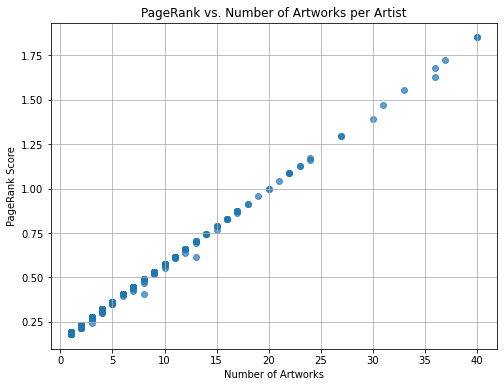

In [66]:
## Plot the relationship in a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_combined['num_artworks'], df_combined['pagerank'], alpha=0.7)
plt.xlabel("Number of Artworks")
plt.ylabel("PageRank Score")
plt.title("PageRank vs. Number of Artworks per Artist")
plt.grid(True)
plt.show()

In [78]:
query = """
CALL gds.pageRank.stream('met_graph')
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS artist, score
WHERE 'Artist' IN labels(artist)
MATCH (artist)<-[:CREATED_BY]-(aw:Artwork)-[:ASSOCIATED_WITH]->(tp:TimePeriod)
RETURN artist.name AS artist_name, score AS pagerank, tp.century AS time_period
"""
df_artist_periods = my_neo4j_run_query_pandas(query)

In [79]:
df_artist_periods.head()

,artist_name,pagerank,time_period
0,Louis Benjamin Huber Defeuille,0.192500,18th Century CE
1,Jacques Thouron,0.266875,18th Century CE
2,Jacques Thouron,0.266875,18th Century CE
3,Jacques Thouron,0.266875,18th Century CE
4,Jean-Baptiste Nini,0.192500,18th Century CE


In [92]:
## Create a categorized order for better plot readability

ordered_centuries = [
    "7th Century CE",
    "9th Century CE",
    "12th Century CE",
    "13th Century CE",
    "14th Century CE",
    "15th Century CE",
    "16th Century CE",
    "17th Century CE",
    "18th Century CE",
    "19th Century CE",
    "20th Century CE",
    "21th Century CE"
]

df_artist_periods['time_period'] = pd.Categorical(
    df_artist_periods['time_period'],
    categories=ordered_centuries,
    ordered=True
)

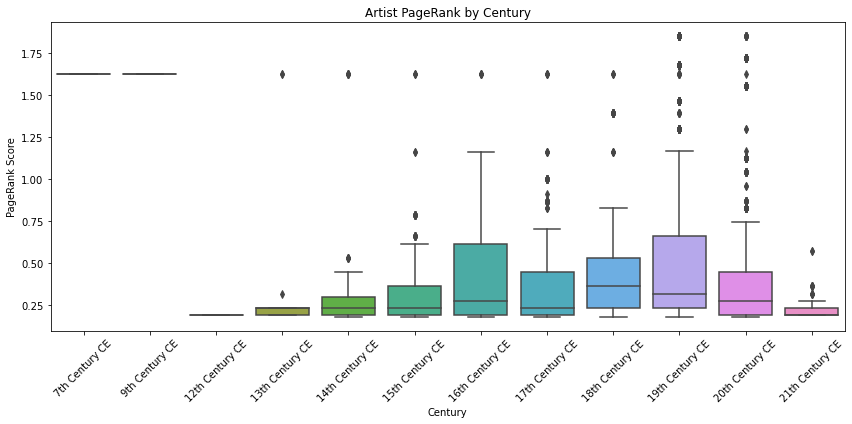

In [93]:
## Plot the distribution of artists' average scores in each century

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_artist_periods, x='time_period', y='pagerank')
plt.title("Artist PageRank by Century")
plt.xlabel("Century")
plt.ylabel("PageRank Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We can see from this box plot that artists from the 18th and 19th centuries generally have a higher page rank score. Art movements associated with these time periods are Romanticism, Cubism, Fauvism, and Impressionism, which are some of the most recognizable movements in museum's in general. Artists from these time periods tend to have more influence within the graph. The 16th century, known for its Renaissance and Baroque paintings, also has higher average scores, showing the strong influence of those time periods.

There are many artists from the 20th century, but their average scores tend to be lower. It would be interesting to see how these scores change over time as we move later into the 21st century. Will these artists start to become as influential or more so than the 18th and 19th century artists? 